In [65]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GSM to Python Project

In [66]:
# determine the current project folder
import pathlib

# determine the current project folder
project_folder = pathlib.Path().parent.absolute()
project_folder

WindowsPath('c:/Users/Lenovo/Desktop/Malik-Burcu-LAB/GSM-to-python')

# Seeds

In [67]:
# set specific seeds
import numpy as np
import random

np.random.seed(44)
random.seed(44)

# User Input Parameters

In [406]:
NUMBER_OF_ITERATION = 1
MODEL_NAME = "DecisionTree" # DecisionTree, RandomForest, SVM, KNN, MLP
LABEL_OF_POSITIVE_CLASS = "pos"
LABEL_OF_NEGATIVE_CLASS = "neg"
CLASS_MIN_BALANCE_RATIO = 0.1 # this is to handle imbalanced data by undersampling the majority class 
# (e.g. if the ratio is 0.5, the majority class has 1000 samples, and the minority class has 200 samples, then the majority class will be undersampled to 400 samples)
TRAIN_TEST_RATIO = 0.5

NORMALIZATION = "minmax" # minmax, zscore
FILTER_FEATURES_BY_TTEST_TO = 1000 # 0 to disable
FILTER_BEST_X_GROUPS = 100

# Input

In [407]:
# read the csv input from data folder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read the csv input from data folder
data_folder = project_folder / "data"
data_file = data_folder / "gds1962_csv.csv"
data = pd.read_csv(data_file)

In [408]:
# print the first 5 rows of the data
data.head()

,class,MIR4640,PAX8,EPHB3,SPATA17,PRR22,PRR22 (#1),SLC39A5,NEXN,MFAP3,...,FAXDC2 (#1),SLC48A1 (#2),DTX3 (#3),SIGIRR (#1),SIDT2 (#1),HIF1AN (#2),MIR1306 (#2),FAM86DP,ADGRA2 (#1),EHBP1L1 (#3)
0,neg,4701.5,1616.3,107.5,13.3,56.2,291.1,205.2,219.3,42.6,...,3960.7,2253.8,554.5,606.9,2954.2,495.1,422.6,441.5,336.8,215.8
1,neg,4735.0,1527.2,270.8,12.8,51.2,209.5,265.3,109.2,77.7,...,3799.2,2528.8,626.8,868.3,2760.5,425.5,488.2,359.7,376.4,269.6
2,neg,2863.9,1793.8,300.8,15.2,32.0,198.2,137.1,197.8,26.6,...,3183.7,1589.7,306.8,530.2,2268.3,450.0,290.8,380.9,373.5,269.5
3,neg,5350.2,1880.0,163.2,19.1,48.6,275.8,403.5,135.7,78.9,...,4561.0,2048.9,496.6,781.7,3049.4,425.1,602.2,376.8,475.1,205.6
4,neg,4789.4,1012.0,221.4,11.9,40.5,145.0,44.1,70.3,123.2,...,3085.4,2859.0,552.6,568.5,2531.6,456.8,315.1,330.6,282.1,240.4


In [409]:
# give information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Columns: 5462 entries, class to EHBP1L1 (#3)
dtypes: float64(5461), object(1)
memory usage: 7.5+ MB


In [410]:
# the input is like::
# class	MIR4640	PAX8	EPHB3	SPATA17	PRR22	PRR22 (#1)	SLC39A5	NEXN	MFAP3	...	FAXDC2 (#1)	SLC48A1 (#2)	DTX3 (#3)	SIGIRR (#1)	SIDT2 (#1)	HIF1AN (#2)	MIR1306 (#2)	FAM86DP	ADGRA2 (#1)	EHBP1L1 (#3)
# 0	neg	4701.5	1616.3	107.5	13.3	56.2	291.1	205.2	219.3	42.6	...	3960.7	2253.8	554.5	606.9	2954.2	495.1	422.6	441.5	336.8	215.8
# 1	neg	4735.0	1527.2	270.8	12.8	51.2	209.5	265.3	109.2	77.7	...	3799.2	2528.8	626.8	868.3	2760.5	425.5	488.2	359.7	376.4	269.6

## Missing Values

In [411]:
# get rid of missing values and measure how many rows are removed
print("Before dropping missing values: ", data.shape)
data = data.dropna()
print("After dropping missing values: ", data.shape)

Before dropping missing values:  (180, 5462)
After dropping missing values:  (180, 5462)


## Group File

In [412]:
# get group file from data / group_file / {file}
# its format is like::
# geneSymbol	diseaseName
# A1BG	Glioblastoma
# A1BG	Meningioma
# A1BG	Subependymal Giant Cell Astrocytoma

group_file = data_folder / "group_file" / "cancer-DisGeNET.txt"
group = pd.read_csv(group_file, sep="\t")
group.tail()

,geneSymbol,diseaseName
329931,LNC-LBCS,Hormone refractory prostate cancer
329932,MIR223HG,leukemia
329933,MIR223HG,"Leukemia, Myelocytic, Acute"
329934,MIR223HG,Leukemogenesis
329935,MIR223HG,Childhood Leukemia


In [413]:
# The output of group file is like this:

# 	geneSymbol	diseaseName
# 329931	LNC-LBCS	Hormone refractory prostate cancer
# 329932	MIR223HG	leukemia
# 329933	MIR223HG	Leukemia, Myelocytic, Acute

### Get Unique Disease Names

In [414]:
diseases = group["diseaseName"].unique()
print("Number of diseases: ", len(diseases))
print("Diseases: ", diseases)

Number of diseases:  3929
Diseases:  ['Glioblastoma' 'Meningioma' 'Subependymal Giant Cell Astrocytoma' ...
 "Leukemic Phase of Non-Hodgkin's Lymphoma"
 'Thyroid Gland Follicular Carcinoma, Encapsulated Angioinvasive'
 'Thyroid Gland Follicular Carcinoma, Widely Invasive']


# GSM

## Sample by the smallest class

In [415]:
# Measure the amount of samples for each class.
# Then, pick the class with the least amount of samples and reduce the other classes to the same amount.
# This is to avoid the problem of imbalanced data.

# get the number of samples for each class
print("Number of samples for each class:")
print(data["class"].value_counts())

# get the class with the least amount of samples
min_samples = data["class"].value_counts().min()
print("Minimum number of samples: ", min_samples)

# reduce the other classes to the amount of specified ratio
data = data.groupby("class").head(min_samples / CLASS_MIN_BALANCE_RATIO)
print("Number of samples for each class after reducing:")
print(data["class"].value_counts())

Number of samples for each class:
class
pos    157
neg     23
Name: count, dtype: int64
Minimum number of samples:  23
Number of samples for each class after reducing:
class
pos    157
neg     23
Name: count, dtype: int64


## Normalization

In [416]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# apply normalization
if NORMALIZATION == "minmax":
    scaler = MinMaxScaler()
elif NORMALIZATION == "zscore":
    scaler = StandardScaler()
else:
    raise Exception("Invalid normalization method")

# get the data without the class column
data_without_class = data.drop("class", axis=1)

# normalize the data
data_normalized = scaler.fit_transform(data_without_class)

# convert the normalized data to a dataframe
data_normalized = pd.DataFrame(data_normalized, columns=data_without_class.columns)

# add the class column to the normalized data at the beginning
data_normalized.insert(0, "class", data["class"])


In [417]:
data_normalized.head(2)

,class,MIR4640,PAX8,EPHB3,SPATA17,PRR22,PRR22 (#1),SLC39A5,NEXN,MFAP3,...,FAXDC2 (#1),SLC48A1 (#2),DTX3 (#3),SIGIRR (#1),SIDT2 (#1),HIF1AN (#2),MIR1306 (#2),FAM86DP,ADGRA2 (#1),EHBP1L1 (#3)
0,neg,0.163395,0.467286,0.024423,0.007781,0.464839,0.44214,0.371837,0.223859,0.071343,...,0.733389,0.176675,0.022251,0.499469,0.426978,0.752573,0.254022,0.187970,0.275770,0.253134
1,neg,0.166024,0.404601,0.163390,0.007376,0.405244,0.28397,0.504070,0.079048,0.155657,...,0.685161,0.203277,0.026035,0.730919,0.378974,0.603345,0.319576,0.134488,0.323963,0.321949


## Split Data by Train and Test

In [418]:
# split the data into train and test
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_normalized, test_size=1 - TRAIN_TEST_RATIO, stratify=data["class"])
print("Number of training samples: ", len(train))
print("Number of test samples: ", len(test))

Number of training samples:  90
Number of test samples:  90


## Filter Features by TTest

In [419]:
# apply one-way anova
from scipy import stats

# apply anova (levene test) to the data
# sort the features by p-value

def apply_anova_levene_test(data, FILTER_FEATURES_BY_TTEST_TO):
    # get the features
    features = data.columns[1:]

    # get the labels
    labels = data["class"].unique()

    # get the groups
    groups = data.groupby("class")

    # get the features by p-value
    features_by_pvalue = {}
    for feature in features:
        # get the feature values for each group
        feature_values = [groups.get_group(label)[feature] for label in labels]

        # apply levene test
        pvalue = stats.levene(*feature_values).pvalue

        # store the p-value
        features_by_pvalue[feature] = pvalue

    # convert the p-values to dataframe
    features_by_pvalue = pd.DataFrame.from_dict(features_by_pvalue, orient="index", columns=["pvalue"])

    # sort the features by p-value
    features_by_pvalue = features_by_pvalue.sort_values(by="pvalue")
    
    # take the best FILTER_FEATURES_BY_TTEST_TO amount of features
    features = features_by_pvalue.index[:FILTER_FEATURES_BY_TTEST_TO].to_list()
    
    return features

In [420]:
# apply one-way anova
filtered_features = apply_anova_levene_test(train, FILTER_FEATURES_BY_TTEST_TO)

In [421]:
# filter the data by the features
train_v2 = train[["class"] + filtered_features]
test_v2 = test[["class"] + filtered_features]

In [422]:
test_v2.shape, train_v2.shape

((90, 1001), (90, 1001))

In [423]:
train_v2.head(2)

,class,TOLLIP (#2),AF086242,BC006530 (#1),S1PR5 (#2),PLD1 (#6),DIRAS1 (#1),236873_at,PCM1 (#1),PIEZO1,...,COQ8B,SLC1A7 (#2),SP4 (#1),LINC00540,ARSA (#1),238894_at,PHF20L1 (#4),AI690081,ENO3,TDH (#1)
13,neg,0.046013,0.109094,0.055249,0.862700,0.534991,0.012567,0.035088,0.006258,0.108462,...,0.282004,0.429092,0.441520,0.167848,0.804239,0.407739,0.510593,0.283071,0.330699,0.189707
154,pos,0.118665,0.078955,0.280540,0.173913,0.065686,0.027528,0.454127,0.122485,0.302652,...,0.583562,0.068071,0.341855,0.408769,0.265087,0.567539,0.624485,0.012026,0.354103,0.046080


## Scoring

In [424]:
# Take each column separately
# Split it into 80:20 ratio for training and testing
# Apply the normalization method
# Train the model with the selected model
# Predict the test data
# Calculate the necessary metrics
# Repeat the process 5 times
# Calculate the average of the metrics

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# split the data into train and test
def split_data(data):
    # get the features
    features = data.columns[1:]
    # get the class labels
    labels = data["class"]
    # split the data into train and test
    train_x, test_x, train_y, test_y = train_test_split(data[features], labels, test_size=0.2, random_state=42)
    # return the train and test data
    return train_x, test_x, train_y, test_y

# normalize the data
def normalize_data(train_x, test_x, NORMALIZATION):
    # normalize the data
    if NORMALIZATION == "minmax":
        # create the scaler
        scaler = preprocessing.MinMaxScaler()
    elif NORMALIZATION == "zscore":
        # create the scaler
        scaler = preprocessing.StandardScaler()
    # fit the scaler
    scaler.fit(train_x)
    # normalize the train and test data
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)
    # return the normalized train and test data
    return train_x, test_x

# train the model
def train_model(train_x, train_y, MODEL_NAME):
    # train the model
    if MODEL_NAME == "DecisionTree":
        # create the model
        model = DecisionTreeClassifier()
    elif MODEL_NAME == "RandomForest":
        # create the model
        model = RandomForestClassifier()
    elif MODEL_NAME == "SVM":
        # create the model
        model = svm.SVC()
    elif MODEL_NAME == "KNN":
        # create the model
        model = KNeighborsClassifier()
    elif MODEL_NAME == "MLP":
        # create the model
        model = MLPClassifier()
    # train the model
    model.fit(train_x, train_y)
    # return the model
    return model

In [425]:
# calculate the metrics
def calculate_metrics(test_y, predicted_y):
    # calculate the metrics
    accuracy = accuracy_score(test_y, predicted_y)
    precision = precision_score(test_y, predicted_y, pos_label=LABEL_OF_POSITIVE_CLASS)
    recall = recall_score(test_y, predicted_y, pos_label=LABEL_OF_POSITIVE_CLASS)
    f1 = f1_score(test_y, predicted_y, pos_label=LABEL_OF_POSITIVE_CLASS)
    # return the metrics
    return accuracy, precision, recall, f1

In [426]:


# combine all the steps
def scoring_module(data, NUMBER_OF_ITERATION, MODEL_NAME, NORMALIZATION):
    # create a list to store the metrics
    metrics = []
    # repeat the process NUMBER_OF_ITERATION times
    for i in range(NUMBER_OF_ITERATION):
        # split the data into train and test
        train_x, test_x, train_y, test_y = split_data(data)
        # normalize the data
        train_x, test_x = normalize_data(train_x, test_x, NORMALIZATION)
        # train the model
        model = train_model(train_x, train_y, MODEL_NAME)
        # predict the test data
        predicted_y = model.predict(test_x)
        # calculate the metrics
        accuracy, precision, recall, f1 = calculate_metrics(test_y, predicted_y)
        # store the metrics
        metrics.append([accuracy, precision, recall, f1])
    # return the metrics
    return metrics

# calculate the average of the metrics
def calculate_average(metrics):
    # calculate the average of the metrics
    return np.mean(metrics, axis=0)

In [427]:
# split the data by each column and calculate the average of the metrics for each of them
def apply_scoring_to_each_features(data, NUMBER_OF_ITERATION, MODEL_NAME, NORMALIZATION):
    # get the features
    features = data.columns[1:]
    # create a dataframe to store the average of the metrics
    average_metrics = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], index=features)
    # for each feature
    for feature in features:
        scoring_module_data = data[["class", feature]]
        # calculate the average of the metrics
        metrics = scoring_module(scoring_module_data, NUMBER_OF_ITERATION, MODEL_NAME, NORMALIZATION)
        # calculate the average of the metrics
        average = calculate_average(metrics)
        # store the average of the metrics
        average_metrics.loc[feature] = average
    # return the average of the metrics
    return average_metrics

In [428]:
# split the data by each column and calculate the average of the metrics for each of them
scored_features = apply_scoring_to_each_features(train_v2, NUMBER_OF_ITERATION, MODEL_NAME, NORMALIZATION)

In [429]:
scored_features.shape

(1000, 4)

In [430]:
scored_features.head() 

,accuracy,precision,recall,f1
TOLLIP (#2),0.833333,0.9375,0.882353,0.909091
AF086242,0.888889,0.941176,0.941176,0.941176
BC006530 (#1),0.777778,0.933333,0.823529,0.875
S1PR5 (#2),0.833333,1.0,0.823529,0.903226
PLD1 (#6),0.833333,1.0,0.823529,0.903226


In [431]:
# sort the average of the metrics by f1 score
scored_features = scored_features.sort_values(by="f1", ascending=False)
scored_features

,accuracy,precision,recall,f1
ZNF43,1.0,1.0,1.0,1.0
AK027041,1.0,1.0,1.0,1.0
KLC3 (#2),1.0,1.0,1.0,1.0
RHBDF1,1.0,1.0,1.0,1.0
AA026390,1.0,1.0,1.0,1.0
...,...,...,...,...
ACADVL,0.555556,0.909091,0.588235,0.714286
F11R (#3),0.555556,0.909091,0.588235,0.714286
KY (#1),0.555556,0.909091,0.588235,0.714286
SPATS2,0.555556,0.909091,0.588235,0.714286


## Grouping

In [432]:
# some columns are like "PRR22 (#1)" or "SLC48A1 (#2)" 
# but we need to remove the (#1) or (#2) part in order to make the column name valid while matching them with the group file
import re
def remove_parenthesis(s):
    return re.sub(r'\s*\(.*\)\s*', '', s)

In [433]:
# get the features and find which diseases they are related to
# for each feature, store the diseases it is related to in a dictionary

def get_diseases_of_features(data, group):
    # get the features
    features = data.columns[1:]
    # create a dictionary to store the diseases of features
    diseases_of_features = {}
    # for each feature
    for feature in features:
        # remove the parenthesis from the feature name
        feature_fixed = remove_parenthesis(feature)
        # get the diseases of the feature
        diseases = group[group["geneSymbol"] == feature_fixed]["diseaseName"].to_list()
        # store the diseases of the feature
        # while storing the feature, use it with the original name such as "PRR22 (#1)"
        diseases_of_features[feature] = diseases
    # return the diseases of features
    return diseases_of_features

In [434]:
# get the diseases of features
diseases_of_features = get_diseases_of_features(train_v2, group)

In [435]:
# print the first 6 element of diseases of features
for feature, diseases in list(diseases_of_features.items())[:6]:
    print(feature, diseases)

TOLLIP (#2) []
AF086242 []
BC006530 (#1) []
S1PR5 (#2) ['Glioblastoma', 'leukemia', 'Adult Glioblastoma', 'Childhood Glioblastoma', 'Malignant neoplasm of prostate', 'Prostate carcinoma', 'Glioblastoma Multiforme']
PLD1 (#6) ['Astrocytoma', 'Malignant neoplasm of breast', 'Colorectal Carcinoma', 'Glioma', 'Malignant neoplasm of stomach', 'melanoma', 'Osteosarcoma', 'Conventional (Clear Cell) Renal Cell Carcinoma', 'Superficial spreading malignant melanoma of skin', 'Acral Lentiginous Malignant Melanoma', 'Malignant neoplasm of prostate', 'Osteosarcoma of bone', 'Prostate carcinoma', 'Breast Carcinoma', 'Stomach Carcinoma', 'Hormone refractory prostate cancer', 'Childhood Osteosarcoma', 'Pancreatic Ductal Adenocarcinoma', 'High grade serous carcinoma', 'Malignant neoplasm of colon and/or rectum']
DIRAS1 (#1) ['Astrocytoma', 'Renal Cell Carcinoma', 'Glioblastoma', 'Glioma', 'Adult Glioblastoma', 'Squamous cell carcinoma of esophagus', 'Conventional (Clear Cell) Renal Cell Carcinoma', 'Ch

### Save Group-Feature Matches

In [436]:
# save the diseases of features to a file in the output folder
output_folder = project_folder / "output"
output_folder.mkdir(parents=True, exist_ok=True)
output_file = output_folder / "diseases_of_features.txt"
with open(output_file, "w") as f:
    for feature, diseases in diseases_of_features.items():
        f.write(feature + "\t" + ";".join(diseases) + "\n")

## Assign Ranks For Groups and Features

In [437]:
# for each group, calculate the average of the metrics
def apply_scoring_to_each_group(data, diseases_of_features, scored_features):
    # get the features
    features = data.columns[1:]
    # get the diseases
    diseases = list(set([disease for diseases in diseases_of_features.values() for disease in diseases]))
    # create a dataframe to store the average of the metrics
    average_metrics = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], index=diseases)
    all_group_feature_match_with_metrics = {}
    # for each disease, find the associated features, get the scored features of the disease, and calculate the average of the metrics
    for disease in diseases:
        # get the features of the disease
        features_of_disease = [feature for feature, diseases in diseases_of_features.items() if disease in diseases]
        # get the scored features of the disease
        scored_features_of_disease = scored_features.loc[features_of_disease]
        # calculate the average of the metrics
        average = calculate_average(scored_features_of_disease.values)
        # store the average of the metrics
        average_metrics.loc[disease] = average
        
        # add group column to scored_features_of_disease
        scored_features_of_disease["group"] = disease
        all_group_feature_match_with_metrics[disease] = scored_features_of_disease
        # add a gene column to scored_features_of_disease
        scored_features_of_disease["gene"] = scored_features_of_disease.index
    # convert the all_group_feature_match_with_metrics to a dataframe
    all_group_feature_match_with_metrics = pd.concat(all_group_feature_match_with_metrics)
    # return the average of the metrics
    return average_metrics, all_group_feature_match_with_metrics

In [438]:
# get the average of the metrics for each disease
average_metrics_of_groups, all_group_feature_match_with_metrics_original = apply_scoring_to_each_group(scored_features, diseases_of_features, scored_features)

In [439]:
all_group_feature_match_with_metrics_original.head()

accuracy precision  \
Mesenchymal Cell Neoplasm                  MAPK1 (#6)  0.833333    0.9375   
Epithelioid mesothelioma, malignant        VCAN (#2)   0.777778  0.933333   
                                           ETFA        0.833333    0.9375   
                                           AQP1 (#1)   0.833333    0.9375   
Growth Hormone-Secreting Pituitary Adenoma PTTG1       0.944444  0.944444   

                                                         recall        f1  \
Mesenchymal Cell Neoplasm                  MAPK1 (#6)  0.882353  0.909091   
Epithelioid mesothelioma, malignant        VCAN (#2)   0.823529     0.875   
                                           ETFA        0.882353  0.909091   
                                           AQP1 (#1)   0.882353  0.909091   
Growth Hormone-Secreting Pituitary Adenoma PTTG1            1.0  0.971429   

                                                                                            group  \
Mesenchymal Cell Neoplasm                  MAPK1 (#6)                   Mesenchymal Cell Neoplasm   
Epithelioid mesothelioma, malignant        VCAN (#2)          Epithelioid mesothelioma, malignant   
                                           ETFA               Epithelioid mesothelioma, malignant   
                                           AQP1 (#1)          Epithelioid mesothelioma, malignant   
Growth Hormone-Secreting Pituitary Adenoma PTTG1       Growth Hormone-Secreting Pituitary Adenoma   

                                                             gene  
Mesenchymal Cell Neoplasm                  MAPK1 (#6)  MAPK1 (#6)  
Epithelioid mesothelioma, malignant        VCAN (#2)    VCAN (#2)  
                                           ETFA              ETFA  
                                           AQP1 (#1)    AQP1 (#1)  
Growth Hormone-Secreting Pituitary Adenoma PTTG1            PTTG1

In [440]:
all_group_feature_match_with_metrics = all_group_feature_match_with_metrics_original.reset_index(drop=True)
all_group_feature_match_with_metrics

,accuracy,precision,recall,f1,group,gene
0,0.833333,0.9375,0.882353,0.909091,Mesenchymal Cell Neoplasm,MAPK1 (#6)
1,0.777778,0.933333,0.823529,0.875,"Epithelioid mesothelioma, malignant",VCAN (#2)
2,0.833333,0.9375,0.882353,0.909091,"Epithelioid mesothelioma, malignant",ETFA
3,0.833333,0.9375,0.882353,0.909091,"Epithelioid mesothelioma, malignant",AQP1 (#1)
4,0.944444,0.944444,1.0,0.971429,Growth Hormone-Secreting Pituitary Adenoma,PTTG1
...,...,...,...,...,...,...
18950,0.777778,0.933333,0.823529,0.875,Luminal B Breast Carcinoma,TP53 (#1)
18951,0.722222,0.928571,0.764706,0.83871,Luminal B Breast Carcinoma,GLS (#1)
18952,0.722222,0.928571,0.764706,0.83871,Luminal B Breast Carcinoma,ERCC1 (#2)
18953,0.777778,1.0,0.764706,0.866667,Luminal B Breast Carcinoma,MKI67 (#3)


## Save Group Feature Matches with Metrics

In [441]:
# save all_group_feature_matches to a csv file in the output folder
output_folder = project_folder / "output"
output_folder.mkdir(parents=True, exist_ok=True)
output_file = output_folder / "all_group_feature_matches.csv"
all_group_feature_match_with_metrics.to_csv(output_file, index=False)

In [442]:
# sort the average of the metrics by accuracy
average_metrics_of_groups = average_metrics_of_groups.sort_values(by="accuracy", ascending=False)

In [443]:
average_metrics_of_groups

,accuracy,precision,recall,f1
Colorectal Intraepithelial Neoplasia,1.0,1.0,1.0,1.0
Fish Melanoma,1.0,1.0,1.0,1.0
Non-seminoma testicular cancer,1.0,1.0,1.0,1.0
Myxoid chondrosarcoma,1.0,1.0,1.0,1.0
Benign endometrial stromal neoplasm,0.944444,0.944444,1.0,0.971429
...,...,...,...,...
Adult Acute Erythroid Leukemia,0.611111,0.916667,0.647059,0.758621
"Anaplastic Large Cell Lymphoma, ALK-Positive",0.611111,0.916667,0.647059,0.758621
Anaplastic lymphoma kinase positive anaplastic large cell lymphoma,0.611111,0.916667,0.647059,0.758621
Pulmonary lymphangioleiomyomatosis,0.611111,0.916667,0.647059,0.758621


### Save Ranked Groups

In [444]:
# save the average of the metrics to a file in the output folder
output_folder = project_folder / "output"
output_folder.mkdir(parents=True, exist_ok=True)
output_file = output_folder / "average_metrics_of_groups.txt"
average_metrics_of_groups.to_csv(output_file, sep="\t")

In [445]:
# find in average_metrics index and print it with its metrics and rank 
name = "Thymic Adenosquamous Carcinoma"
print(average_metrics_of_groups.index.get_loc(name) + 1)
print(average_metrics_of_groups.loc[name])

534
accuracy     0.833333
precision         1.0
recall       0.823529
f1           0.903226
Name: Thymic Adenosquamous Carcinoma, dtype: object


## Remove Lower Scored Groups 

In [446]:
# Take the best performed groups (diseases)
# Find the associated features to these groups and filter them
def filter_features_by_diseases(data, diseases_of_features, average_metrics_of_groups, FILTER_BEST_X_GROUPS):
    # get the best performed groups (diseases)
    best_performed_groups = average_metrics_of_groups.index[:FILTER_BEST_X_GROUPS].to_list()
    # for each group, get associated features and store them in a list
    features_of_best_performed_groups = []
    for group in best_performed_groups:
        features_of_best_performed_groups += [feature for feature, diseases in diseases_of_features.items() if group in diseases]
    # remove the duplicate features
    print("Number of features before removing duplicates: ", len(features_of_best_performed_groups))
    features_of_best_performed_groups = list(set(features_of_best_performed_groups))
    print("Duplicate features are removed. Number of features: ", len(features_of_best_performed_groups))
    # filter the data by the features
    data = data[["class"] + features_of_best_performed_groups]
    # return the filtered data and features_of_best_performed_groups
    return data, features_of_best_performed_groups

In [447]:
# filter the data by the features_of_best_performed_groups
train_v3, features_of_best_performed_groups  = filter_features_by_diseases(train_v2, diseases_of_features, average_metrics_of_groups, FILTER_BEST_X_GROUPS)
test_v3 = test_v2[["class"] + features_of_best_performed_groups]

Number of features before removing duplicates:  125
Duplicate features are removed. Number of features:  43


In [448]:
# turn the class labels into 0 and 1
train_v3["class"] = train_v3["class"].apply(lambda x: 1 if x == LABEL_OF_POSITIVE_CLASS else 0)
# do it for test_v3 as well
test_v3["class"] = test_v3["class"].apply(lambda x: 1 if x == LABEL_OF_POSITIVE_CLASS else 0)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8460\1509008421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_v3["class"] = train_v3["class"].apply(lambda x: 1 if x == LABEL_OF_POSITIVE_CLASS else 0)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8460\1509008421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_v3["class"] = test_v3["class"].apply(lambda x: 1 if x == LABEL_OF_POSITIVE_CLASS else 0)


In [449]:
features_of_best_performed_groups

['SUZ12 (#2)',
 'TNRC6B (#5)',
 'TBX19',
 'CCDC6 (#1)',
 'CACNG5',
 'RB1',
 'HOXA10 (#1)',
 'ASCL1 (#2)',
 'TNK2 (#2)',
 'SOX11 (#1)',
 'NR6A1 (#1)',
 'SHMT1 (#1)',
 'AIMP2',
 'GNAS (#10)',
 'MAPK1 (#6)',
 'GPC4 (#1)',
 'CREB1 (#6)',
 'CFLAR (#6)',
 'TP53 (#1)',
 'CDH11 (#2)',
 'PCM1 (#1)',
 'PTTG1',
 'CLCN5 (#3)',
 'NRP2 (#8)',
 'BRF1',
 'ASCL2',
 'CDK2 (#2)',
 'KDM6B (#4)',
 'RACGAP1',
 'ETV1',
 'ATP1A4 (#1)',
 'TBL1XR1 (#2)',
 'TRIM21',
 'PDLIM5 (#7)',
 'TLR3 (#2)',
 'TRPS1 (#3)',
 'VEGFA',
 'LPAR6 (#1)',
 'DUT',
 'MR1 (#3)',
 'NOTCH2 (#3)',
 'GNA12 (#1)',
 'HMMR']

In [450]:
train_v3.head(10)

,class,SUZ12 (#2),TNRC6B (#5),TBX19,CCDC6 (#1),CACNG5,RB1,HOXA10 (#1),ASCL1 (#2),TNK2 (#2),...,PDLIM5 (#7),TLR3 (#2),TRPS1 (#3),VEGFA,LPAR6 (#1),DUT,MR1 (#3),NOTCH2 (#3),GNA12 (#1),HMMR
13,0,0.308095,0.243868,0.365772,0.138521,0.218931,0.435253,0.022033,0.031735,0.168190,...,0.025302,0.085677,0.127181,0.074873,0.245633,0.449332,0.175893,0.117430,0.121409,0.050867
154,1,0.038607,0.302707,0.341387,0.123244,0.470379,0.494652,0.043627,0.339837,0.185411,...,0.219400,0.116416,0.303578,0.058250,0.209464,0.351570,0.587529,0.509800,0.304055,0.062868
58,1,0.451917,0.336574,0.440492,0.284477,0.163697,0.756674,0.220986,0.132960,0.054211,...,0.102030,0.329627,0.156309,0.344815,0.430557,0.378303,0.485586,0.544763,0.217557,0.152369
39,1,0.431438,0.603825,0.287919,0.045755,0.020045,0.792915,0.098004,0.311393,0.117043,...,0.276646,0.082407,0.513622,0.088528,0.362658,0.656046,0.404638,0.576309,0.256004,0.119232
166,1,0.287939,0.464671,0.215436,0.309238,0.073942,0.267018,0.014793,0.361719,0.704921,...,0.477797,0.049052,0.383804,0.045977,0.037864,0.890115,0.180280,0.459902,0.457890,0.103825
59,1,0.192273,0.429089,0.206711,0.228545,0.564588,0.467310,0.003855,0.524114,0.277953,...,0.693972,0.327011,0.517514,0.066063,0.143008,0.536991,0.404429,0.244804,0.536010,0.061939
173,1,0.539327,0.228110,0.299553,0.354968,0.123385,0.778626,0.170903,0.757699,0.260119,...,0.127111,0.250491,0.108977,0.071448,0.413136,0.686043,0.184145,0.658818,0.259460,0.249613
116,1,0.000000,0.416826,0.605593,0.355352,0.411359,0.510990,0.027110,0.521496,0.064153,...,0.445031,0.455199,0.562461,0.271947,0.431564,0.466428,0.209317,0.675123,0.723450,0.156240
102,1,0.102953,0.142903,0.708054,0.174203,0.551225,0.467984,0.028364,0.088659,0.042565,...,0.235562,0.349248,0.161205,0.312227,0.451343,0.436121,0.378003,0.417349,0.206281,0.213069
62,1,0.362392,0.487800,0.404922,0.299882,0.207127,0.602672,0.139186,0.333312,0.088328,...,0.214182,0.407456,0.425989,0.065066,0.444635,0.351725,0.438166,0.396113,0.564296,0.089811


## Modeling

In [461]:
def calculate_metrics(test_y, predicted_y):
    # calculate the metrics
    accuracy = accuracy_score(test_y, predicted_y)
    precision = precision_score(test_y, predicted_y)
    recall = recall_score(test_y, predicted_y)
    f1 = f1_score(test_y, predicted_y)
    # return the metrics
    return accuracy, precision, recall, f1

# take the final data, train a model with it and calculate the metrics using test data
def final_scoring_module(train, test, MODEL_NAME):
    # split the data into labels and features
    train_x = train.drop("class", axis=1)
    train_y = train["class"]
    test_x = test.drop("class", axis=1)
    test_y = test["class"]
    # train the model
    model = train_model(train_x, train_y, MODEL_NAME)
    try:
        # predict the probability of test data
        predicted_y_proba = model.predict_proba(test_x)
        print(predicted_y_proba)
        # get the probability of the positive class
        predicted_y_proba = predicted_y_proba[:, 1]
    except:
        print("The probability of test data cannot be predicted. The model does not have the attribute 'predict_proba'")
        # predict the test data
        predicted_y_proba = model.predict(test_x)
    # convert the predicted_y_proba to binary
    predicted_y = np.where(predicted_y_proba > 0.5, 1, 0)
    # calculate the metrics
    accuracy, precision, recall, f1 = calculate_metrics(test_y, predicted_y)
    # return the metrics
    return accuracy, precision, recall, f1, predicted_y_proba

In [462]:
# calculate the metrics for the final data
accuracy, precision, recall, f1, predicted_y_proba = final_scoring_module(train_v3, test_v3, MODEL_NAME)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Accuracy:  0.9666666666666667
Precision:  0.9746835443037974
Recall:  0.9871794871794872
F1:  0.980891719745223


### Draw a ROC Curve

In [463]:
recall

0.9871794871794872

In [464]:
predicted_y_proba

array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [465]:
predicted_y_proba

array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

AUC:  0.9102564102564104


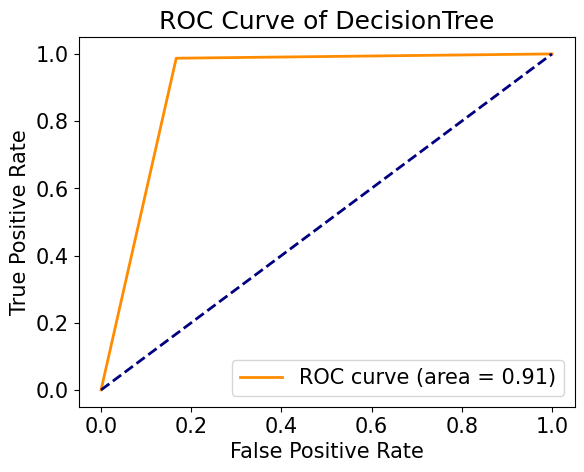

In [466]:
# import lib for precision, recall and roc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


def calculate_roc_values(test_y, predicted_y_proba):
    # calculate the fpr and tpr
    fpr, tpr, thresholds = roc_curve(test_y, predicted_y_proba)
    # calculate the auc manually
    auc_value = np.trapz(tpr, fpr)
    print("AUC: ", auc_value)
    # return the fpr, tpr and auc
    return fpr, tpr, auc_value

def calculate_tpr_fpr(test_y, predicted_y_proba):
    thresholds = np.linspace(0, 1, num=100)
    # calculate the precision and recall manually
    precision = []
    recall = []
    tpr, fpr = [], []
    for threshold in thresholds:
        predicted_y = (predicted_y_proba >= threshold).astype(int)
        tp = np.sum((predicted_y == 1) & (test_y == 1))
        fp = np.sum((predicted_y == 1) & (test_y == 0))
        fn = np.sum((predicted_y == 0) & (test_y == 1))
        tn = np.sum((predicted_y == 0) & (test_y == 0))
        print("tp: ", tp, "fp: ", fp, "fn: ", fn, "tn: ", tn)
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    # calculate the auc
    auc_value = np.trapz(precision, recall)
    # return the precision, recall and auc
    
    print("AUC: ", auc_value)
    print("tpr: ", tpr)
    print("fpr: ", fpr)
    return tpr, fpr, auc_value, thresholds


# calculate the roc values
fpr, tpr, auc_value = calculate_roc_values(test_v3['class'], predicted_y_proba)
# calculate the tpr, fpr, auc and thresholds
# tpr, fpr, auc_value, thresholds = calculate_tpr_fpr(test_v3['class'], predicted_y)

# plot the roc curve
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_value)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_value)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of ' + MODEL_NAME)
plt.legend(loc="lower right")
# make the text bigger
plt.rcParams.update({'font.size': 15})
plt.show()

# draw the precision recall curve
# plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % auc_value)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision Recall Curve')
# plt.legend(loc="lower right")
# plt.show()

In [467]:
fpr, tpr, thresholds

(array([0.        , 0.16666667, 1.        ]),
 array([0.        , 0.98717949, 1.        ]),
 array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66

# Save Results

## Apply Robust Rank Aggregation to Groups

#

In [ ]:
# apply borda rank aggregation for each group
import ranky as rk

def apply_borda_rank_aggregation_for_each_group(all_group_feature_match_with_metrics):
    # get the groups
    groups = all_group_feature_match_with_metrics["group"].unique()
    # create a dataframe to store the aggregated ranks
    aggregated_ranks = pd.DataFrame(columns=["rank", "group"])
    # for each group
    for group in groups:
        # get the features of the group
        features_of_group = all_group_feature_match_with_metrics[all_group_feature_match_with_metrics["group"] == group]
        # get the ranks with the columns "f1", "recall", "precision", "accuracy" and turn into list
        ranks = features_of_group[["f1", "recall", "precision", "accuracy"]].values.tolist()
        # apply borda rank aggregation
        aggregated_ranks_of_group = rk.borda(ranks)
        # store the aggregated ranks
        aggregated_ranks_of_group["group"] = group
        aggregated_ranks = aggregated_ranks.append(aggregated_ranks_of_group)
    # return the aggregated ranks
    return aggregated_ranks

In [ ]:
# apply borda rank aggregation for each group
aggregated_ranks = apply_borda_rank_aggregation_for_each_group(all_group_feature_match_with_metrics)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices